<a href="https://colab.research.google.com/github/duskvirkus/colab-notebooks/blob/main/StyleGAN2-ada-pytorch/SG2_post_training_cleanup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StyleGAN 2 ADA PyTorch Post Training Clean Up

by duskvirkus

For use with SG2-ADA-PyTorch notebook. Assumes you are using google drive and want a file structure as seen in the diagram below.

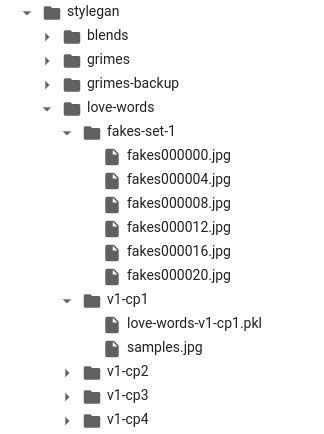

This notebook will move all the files you want to keep from the training session. I suggest double checking it did what you wanted before running the deletion.

**Use this notebook at your own risk.**

I leave my snapshot count set to 1 as I consider the export time to be minimal comared to the amount of time lost if session shuts down. A nice side effect is that you end up saving out more fakes so you can create a runwayml type animation of the training process.

## Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Definitions

In [ ]:
repo_drive_path = '/content/drive/MyDrive/colab-sg2-ada-pytorch/stylegan2-ada-pytorch' # if you installed it somewhere besides the default you have to change this
sg_folder_path = '/content/drive/MyDrive/stylegan' # where you'll be moving the files you want to keep
results_name = '00010-grimes-v1-mirror-11gb-gpu-complex-gamma50-bgc-resumecustom' # 'latest' or the name of the results directory (not the full path)
snapshots_to_keep = ['last'] # valid options include an array with snapshot number and or string with 'last' include or simply a string 'all'
model_name = 'grimes' # just enter the name of you model it's easier than parsing it
rename_to_checkpoints = True
keep_fakes = True
v_num = 1 # I use versions to demarcate what version of a dataset a model was trained on if left blank it won't be included

## Move the Results

### define functions

In [ ]:
# define functions

def get_last_snapshot_path(results_path):
  digits = re.compile('network-snapshot-(\d{6})')
  max_val = -1
  max_name = ''
  for root, dirs, files in os.walk(os.path.join(results_path)):
    for file in files:
      b = digits.match(file)
      if b is not None:
        a = int(b.group(1))
        if a > max_val:
          max_val = a
          max_name = file
  return os.path.join(results_path, max_name)

def get_snapshot_path(results_path, snapshot_index):
  if isinstance(snapshot_index, str):
    snapshot_index = int(snapshot_index)
  digits = re.compile('network-snapshot-(\d{6})')
  for root, dirs, files in os.walk(os.path.join(results_path)):
    for file in files:
      b = digits.match(file)
      if b is not None:
        a = int(b.group(1))
        if a == snapshot_index:
          return os.path.join(results_path, file)
  return None

def get_all_snapshot_paths(results_path):
  snapshot_paths = []
  digits = re.compile('network-snapshot-(\d{6})')
  for root, dirs, files in os.walk(os.path.join(results_path)):
    for file in files:
      b = digits.match(file)
      if b is not None:
        snapshot_paths.append(os.path.join(results_path, file))
  return snapshot_paths


def get_next_checkpoint(check_path):
  digits = re.compile('cp(\d+)')
  max_val = -1
  for root, dirs, files in os.walk(check_path):
    for dir in dirs:
      a = digits.match(dir.split('-')[-1])
      if a is not None:
        b = int(a.group(1))
        max_val = max(b, max_val)

  if max_val != -1:
    return max_val + 1
  return 1

def get_fakes_path(snapshot_path):
  digits = re.compile('network-snapshot-(\d{6})')
  a = digits.match(snapshot_path.split('/')[-1])
  if a is None:
    return None
  b = a.group(1)
  return os.path.join('/'.join(snapshot_path.split('/')[:-1]), 'fakes' + b + '.jpg')

def get_fakes_dir_name(base_path):
  if os.path.isdir(base_path):
    digits = re.compile('fakes-set-(\d+)')
    max_val = -1
    for root, dirs, files in os.walk(base_path):
      for dir in dirs:
        a = digits.match(dir)
        if a is not None:
          b = int(a.group(1))
          max_val = max(b, max_val)

    if max_val != -1:
      return os.path.join(base_path, 'fakes-set-%d' % (max_val + 1))
  return os.path.join(base_path, 'fakes-set-%d' % 1)

### copy files

In [ ]:
import os
import re
import shutil

# validate results folder exists and had snapshots in it

if results_name == 'latest':
  digits = re.compile('\d{5}')
  max_val = -1
  max_name = ''
  for root, dirs, files in os.walk(os.path.join(repo_drive_path, 'results')):
    for dir in dirs:
      a = int(digits.match(dir).group(0))
      if a > max_val:
        max_val = a
        max_name = dir
  results_name = max_name

results_path = os.path.join(repo_drive_path, 'results', results_name)
if not os.path.isdir(results_path):
  print('Error %s is not a directory!' % results_path)
  exit(1)

for root, dirs, files in os.walk(os.path.join(results_path)):
  check = re.compile('network-snapshot')
  found = False
  for file in files:
    if check.match(file):
      found = True
      break
  if not found:
    print("Error! No network snapshots found in %s" % results_path)
    exit(1)

# get snapshot paths

snapshot_paths = []
if isinstance(snapshots_to_keep, str) and snapshots_to_keep.lower() == 'all':
  snapshot_paths = get_all_snapshot_paths(results_path)
else:
  for i in range(len(snapshots_to_keep)):
    if isinstance(snapshots_to_keep[i], str) and snapshots_to_keep[i].lower() == 'last':
      snapshot_paths.append(get_last_snapshot_path(results_path))
    else:
      snapshot_path = get_snapshot_path(results_path, snapshots_to_keep[i])
      if snapshot_path is not None:
        snapshot_paths.append(snapshot_path)
      else:
        print('WARN: looks like "%s" snapshot does not exist!' % snapshots_to_keep[i])

# sort paths by number
snapshot_paths.sort()

# copy

checkpoint = get_next_checkpoint(os.path.join(sg_folder_path, model_name))
for snapshot_path in snapshot_paths:
  v_checkpoint = 'v%d-cp%d' % (v_num, checkpoint)
  new_name = snapshot_path.split('/')[-1]
  if rename_to_checkpoints:
    new_name = '%s-%s.pkl' % (model_name, v_checkpoint)
  dest_pkl = os.path.join(sg_folder_path, model_name, v_checkpoint, new_name)
  checkpoint += 1

  os.makedirs(os.path.join(sg_folder_path, model_name, v_checkpoint), exist_ok=True)

  shutil.copyfile(snapshot_path, dest_pkl)

  src_fakes = get_fakes_path(snapshot_path)
  if src_fakes is not None:
    dest_fakes = os.path.join(sg_folder_path, model_name, v_checkpoint, 'samples.jpg')
    shutil.copyfile(src_fakes, dest_fakes)

# fakes

if keep_fakes:
  fakes_dest_dir = get_fakes_dir_name(os.path.join(sg_folder_path, model_name))
  os.makedirs(fakes_dest_dir)
  fakesre = re.compile('fakes\d+')
  for root, dirs, files in os.walk(os.path.join(results_path)):
    for file in files:
      a = fakesre.match(file)
      if a is not None:
        pass
        shutil.copyfile(os.path.join(root, file), os.path.join(fakes_dest_dir, file))


## <font color='red'>Danger Zone</font>

**Run this with caution automated deleting is always dangerous!**

Please review the code below and check to make sure the previous step worked before running this. If you make a mistake check drive trash because it seems to work but don't count on it.

In [ ]:
import shutil
import os
results_path = os.path.join(repo_drive_path, 'results', results_name)
print('to_delete: %s' % results_path)
in_val = input("please type 'yes' to confirm: ")
if in_val == 'yes':
  shutil.rmtree(results_path)